### Link : https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition

# How I made top 0.3% on a Kaggle competition
Getting started with competitive data science can be quite intimidating. So I wrote this quick overview of how I made top 0.3% on the Advanced Regression Techniques competition. If there is interest, I’m happy to do deep dives into the intuition behind the feature engineering and models used in this kernel.

I encourage you to fork this kernel, play with the code and enter the competition. Good luck!

If you like this kernel, please give it an upvote. Thank you!

## The Goal

- Each row in the dataset describes the characteristics of a house.
- Our goal is to predict the SalePrice, given these features.
- Our models are evaluated on the Root-Mean-Squared-Error (RMSE) between the log of the SalePrice predicted by our model, and the log of the actual SalePrice. Converting RMSE errors to a log scale ensures that errors in predicting expensive houses and cheap houses will affect our score equally.

## Key features of the model training process in this kernel:
- **Cross Validation:** Using 12-fold cross-validation
- **Models:** On each run of cross-validation I fit 7 models (ridge, svr, gradient boosting, random forest, xgboost, lightgbm regressors)
- **Stacking:** In addition, I trained a meta StackingCVRegressor optimized using xgboost
- **Blending:** All models trained will overfit the training data to varying degrees. Therefore, to make final predictions, I blended their predictions together to get more robust predictions.

## Model Performance

We can observe from the graph below that the blended model far outperforms the other models, with an RMSLE of 0.075. This is the model I used for making the final predictions.

In [1]:
import os

pth = os.getcwd()

output_path = pth
input_path = pth

In [2]:
!pip install -q seaborn

## Now that we have some context, let's get started!

In [3]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.svm import SVR


# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import os
import joblib
import json

In [4]:
# Read in the dataset as a dataframe

train_path = os.path.join(input_path,'train.csv') 
test_path = os.path.join(input_path,'test.csv')

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train.shape, test.shape

((1460, 81), (1459, 80))

In [5]:
#Creating a dictionary to dump values to a json file.
dump_file = {}

# EDA

## The Goal

- Each row in the dataset describes the characteristics of a house.
- Our goal is to predict the SalePrice, given these features.

In [6]:
# Preview the data we're working with
train.head(10)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
5         Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
6         Lvl    AllPub    Inside       Gtl      Somerst       Norm   
7         Lvl    AllPub    Corner       Gtl       NWAmes       PosN   
8         Lvl    AllPub    Inside       Gtl      OldTown     Artery   
9         Lvl    AllPub    Corner       Gtl      BrkSide     Artery   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   
5       Norm     1Fam     1.5Fin            5            5       1993   
6       Norm     1Fam     1Story            8            5       2004   
7       Norm     1Fam     2Story            7            6       1973   
8       Norm     1Fam     1.5Fin            7            5       1931   
9     Artery   2fmCon     1.5Unf            5            6       1939   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
5          1995     Gable  CompShg     VinylSd     VinylSd       None   
6          2005     Gable  CompShg     VinylSd     VinylSd      Stone   
7          1973     Gable  CompShg     HdBoard     HdBoard      Stone   
8          1950     Gable  CompShg     BrkFace     Wd Shng       None   
9          1950     Gable  CompShg     MetalSd     MetalSd       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   
5         0.0        TA        TA       Wood       Gd       TA           No   
6       186.0        Gd        TA      PConc       Ex       TA           Av   
7       240.0        TA        TA     CBlock       Gd       TA           Mn   
8         0.0        TA        TA     BrkTil       TA       TA           No   
9       

## SalePrice: the variable we're trying to predict

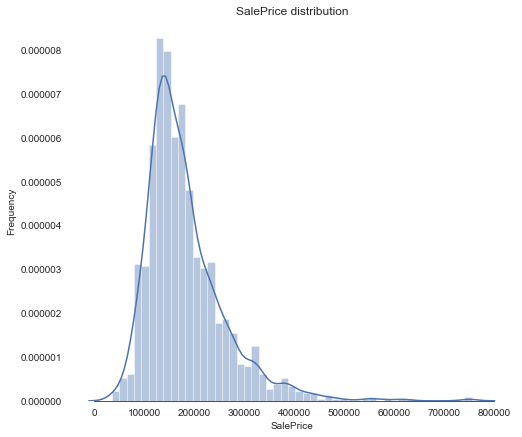

In [7]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

In [8]:
# Skew and kurt
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## Features: a deep dive

Let's visualize some of the features in the dataset

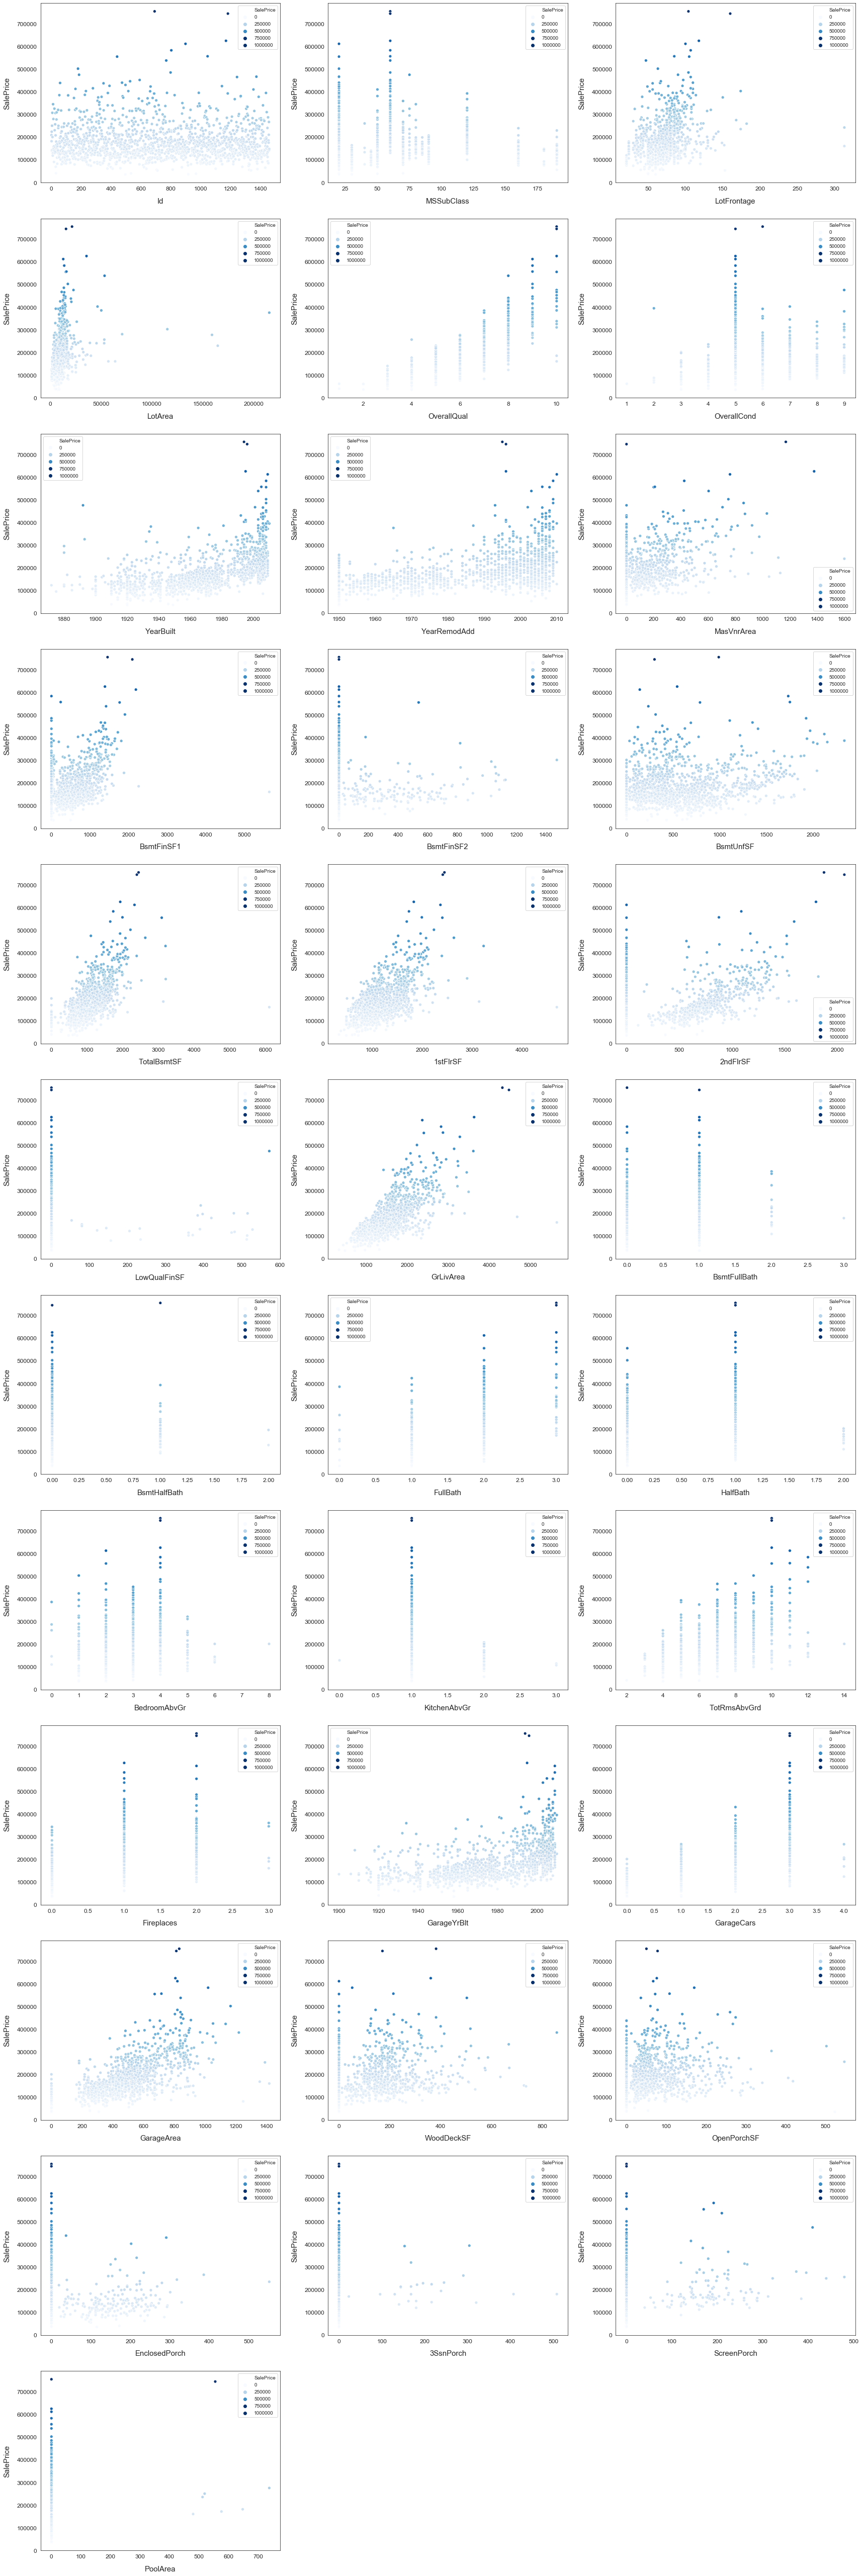

In [9]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)   
            
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

and plot how the features are correlated to each other, and to SalePrice

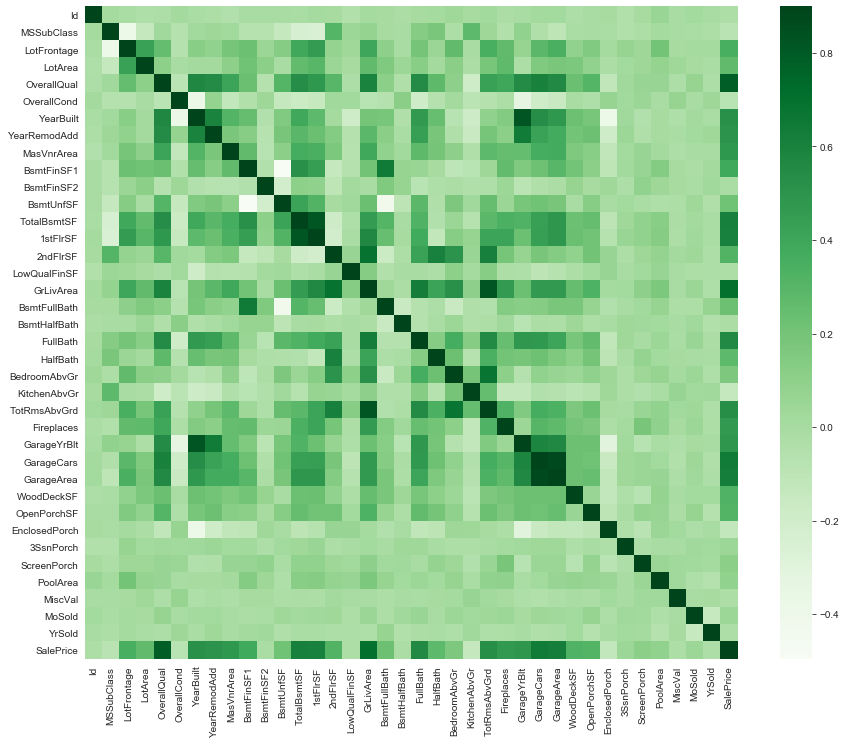

In [10]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="Greens", square=True)

Let's plot how SalePrice relates to some of the features in the dataset

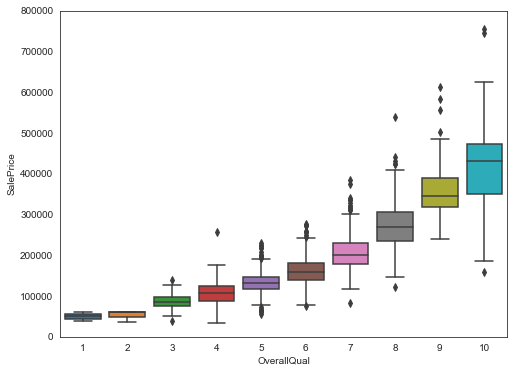

In [11]:
data = pd.concat([train['SalePrice'], train['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=train['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

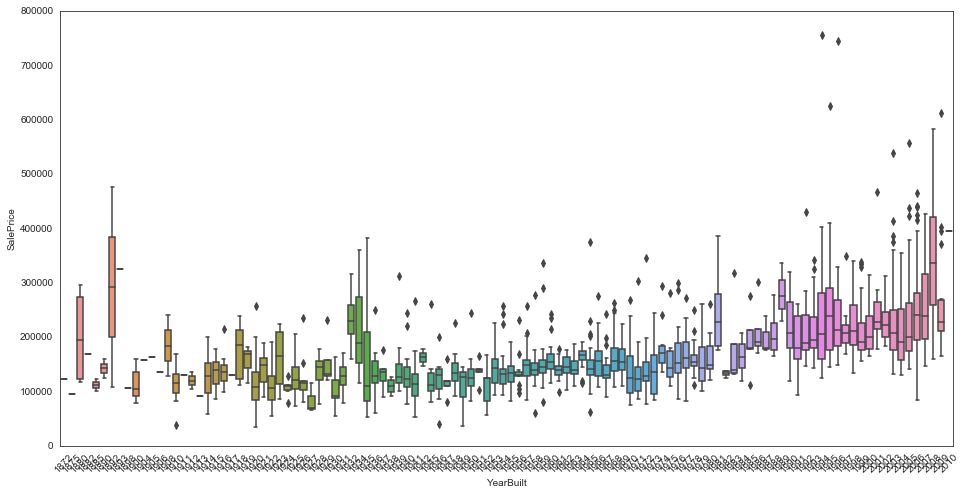

In [12]:
data = pd.concat([train['SalePrice'], train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=train['YearBuilt'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=45);

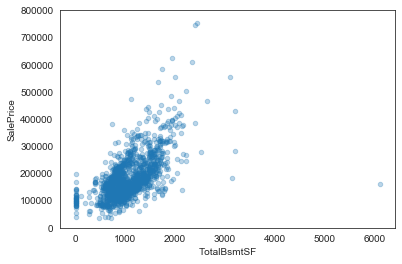

In [13]:
data = pd.concat([train['SalePrice'], train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', alpha=0.3, ylim=(0,800000));

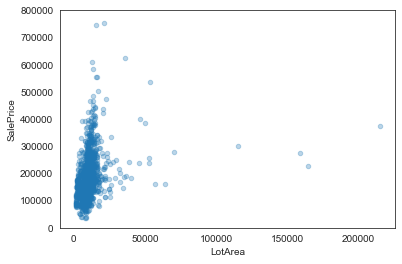

In [14]:
data = pd.concat([train['SalePrice'], train['LotArea']], axis=1)
data.plot.scatter(x='LotArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

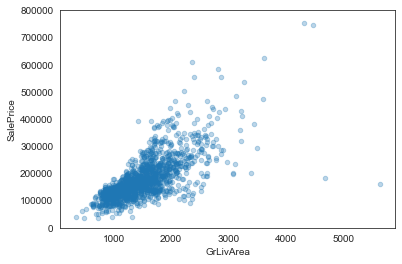

In [15]:
data = pd.concat([train['SalePrice'], train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', alpha=0.3, ylim=(0,800000));

In [16]:
# Remove the Ids from train and test, as they are unique for each row and hence not useful for the model
train_ID = train['Id']
test_ID = test['Id']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
train.shape, test.shape

((1460, 80), (1459, 79))

# Feature Engineering

Let's take a look at the distribution of the SalePrice.

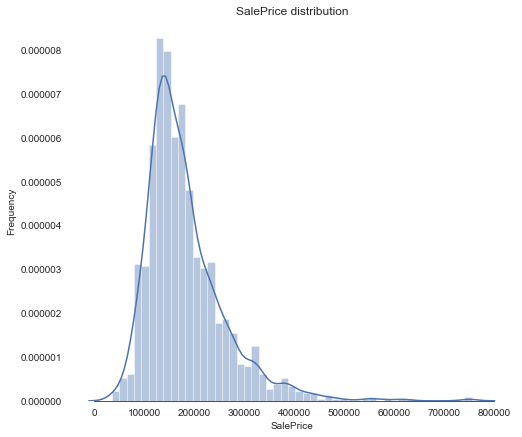

In [17]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

The SalePrice is skewed to the right. This is a problem because most ML models don't do well with non-normally distributed data. We can apply a log(1+x) tranform to fix the skew.

In [18]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])

Let's plot the SalePrice again.


 mu = 12.02 and sigma = 0.40



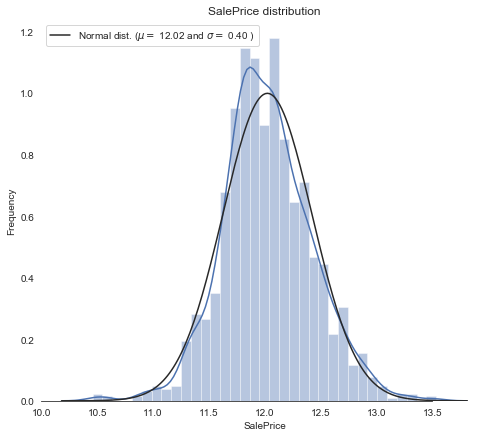

In [19]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm, color="b");

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

The SalePrice is now normally distributed, excellent!

In [20]:
# Remove outliers
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

In [21]:
# Split features and labels
train_labels = train['SalePrice'].reset_index(drop=True)
print(len(train_labels))
train_features = train.drop(['SalePrice'], axis=1)
print(len(train_features))
test_features = test

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

1458
1458


(2917, 79)


## Fill missing values

In [22]:
# determine the threshold for missing values
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[:10]

Percent of missing data


[('PoolQC', 99.69),
 ('MiscFeature', 96.4),
 ('Alley', 93.21),
 ('Fence', 80.43),
 ('FireplaceQu', 48.68),
 ('LotFrontage', 16.66),
 ('GarageYrBlt', 5.45),
 ('GarageFinish', 5.45),
 ('GarageQual', 5.45),
 ('GarageCond', 5.45)]

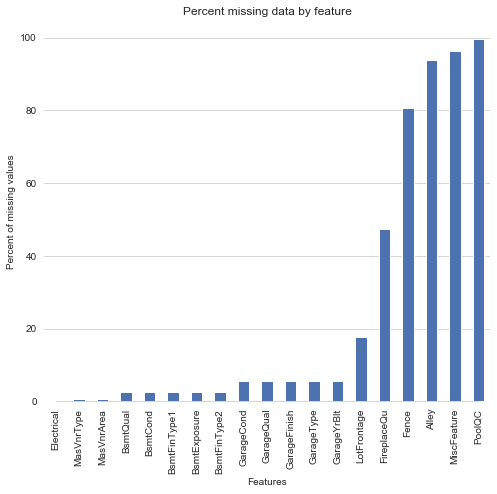

In [23]:
# Visualize missing values
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

We can now move through each of the features above and impute the missing values for each of them.

In [24]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)

In [25]:
#storing the mean,mode and median values form training set.
missing_values = {}

#function to handle the missing values.
def handle_missing(features):
    # the data description states that NA refers to typical ('Typ') values
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each of the columns below with their mode
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    
    missing_values['Exterior1st'] = features['Exterior1st'].mode()[0]
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    
    missing_values['Exterior2nd'] = features['Exterior2nd'].mode()[0]
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    
    missing_values['SaleType'] = features['SaleType'].mode()[0]
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    
    missing_values['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].agg(lambda x: x.mode()[0]).to_dict()
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    missing_values['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].agg(lambda x: (x.median())).to_dict()
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    dump_file['obj_cols'] = objects
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    dump_file['num_cols'] = numeric
    features.update(features[numeric].fillna(0))    
    return features

all_features = handle_missing(all_features)
all_features.shape

(2917, 79)

In [26]:
dump_file['missing_values'] = missing_values

In [27]:
# Let's make sure we handled all the missing values
missing = percent_missing(all_features)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:10]

Percent of missing data


[('MSSubClass', 0.0),
 ('MSZoning', 0.0),
 ('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('Street', 0.0),
 ('Alley', 0.0),
 ('LotShape', 0.0),
 ('LandContour', 0.0),
 ('Utilities', 0.0),
 ('LotConfig', 0.0)]

There are no missing values anymore!

## Fix skewed features

In [28]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

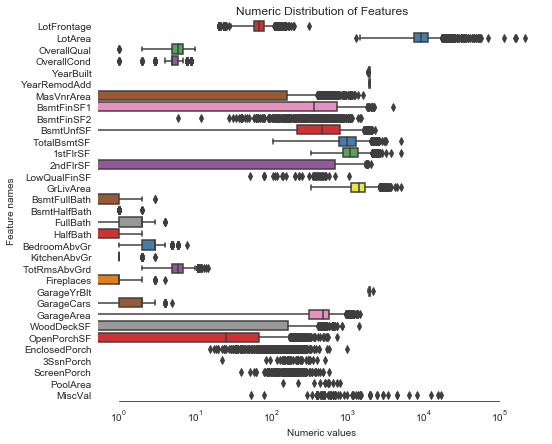

In [29]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [30]:
# Find skewed numerical features
skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})

skew_features.head(10)

There are 25 numerical features with Skew > 0.5 :


MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
dtype: float64

We use the scipy function boxcox1p which computes the Box-Cox transformation. The goal is to find a simple transformation that lets us normalize data.

In [31]:
normalized_features = {}
# Normalize skewed features
for i in skew_index:
    normalized_features[i] = boxcox_normmax(all_features[i] + 1)
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))
    
all_features.shape
dump_file['normalized_features'] = normalized_features

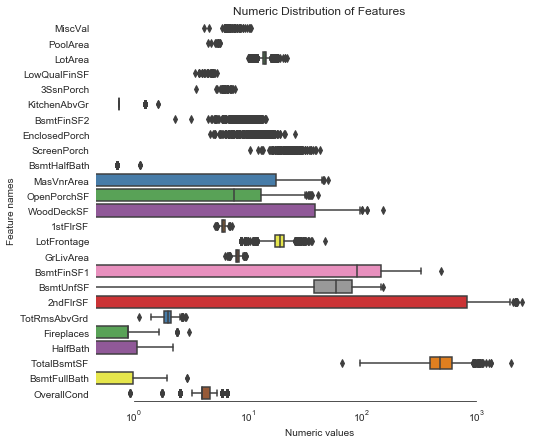

In [32]:
# Let's make sure we handled all the skewed values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=all_features[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

All the features look fairly normally distributed now.

## Create interesting features

ML models have trouble recognizing more complex patterns (and we're staying away from neural nets for this competition), so let's help our models out by creating a few features based on our intuition about the dataset, e.g. total area of floors, bathrooms and porch area of each house.

In [33]:
all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                 all_features['1stFlrSF'] + all_features['2ndFlrSF'])
all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                               all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                              all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                              all_features['WoodDeckSF'])
all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
all_features.shape

(2917, 94)

## Feature transformations
Let's create more features by calculating the log and square transformations of our numerical features. We do this manually, because ML models won't be able to reliably tell if log(feature) or feature^2 is a predictor of the SalePrice.

In [34]:
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

all_features = logs(all_features, log_features)
all_features.shape

(2917, 124)

In [35]:
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']

all_features = squares(all_features, squared_features)
all_features.shape

(2917, 132)

In [36]:
obj_features = all_features.select_dtypes(include=['object'])
obj_cols = list(obj_features.columns)

df = pd.DataFrame(columns = obj_cols)

ls = []
for i in obj_cols:
    ls.append(obj_features[i].unique().tolist())

df['Neighborhood'] = ls[7]
    
for i in range(len(ls)):
    if i == 7:
        continue
    else:
        df[obj_cols[i]] = pd.Series(ls[i])
df

MSSubClass MSZoning Alley LotShape LandContour LotConfig LandSlope  \
0          60       RL  None      Reg         Lvl    Inside       Gtl   
1          20       RM  Grvl      IR1         Bnk       FR2       Mod   
2          70  C (all)  Pave      IR2         Low    Corner       Sev   
3          50       FV   NaN      IR3         HLS   CulDSac       NaN   
4         190       RH   NaN      NaN         NaN       FR3       NaN   
5          45      NaN   NaN      NaN         NaN       NaN       NaN   
6          90      NaN   NaN      NaN         NaN       NaN       NaN   
7         120      NaN   NaN      NaN         NaN       NaN       NaN   
8          30      NaN   NaN      NaN         NaN       NaN       NaN   
9          85      NaN   NaN      NaN         NaN       NaN       NaN   
10         80      NaN   NaN      NaN         NaN       NaN       NaN   
11        160      NaN   NaN      NaN         NaN       NaN       NaN   
12         75      NaN   NaN      NaN         NaN       NaN       NaN   
13        180      NaN   NaN      NaN         NaN       NaN       NaN   
14         40      NaN   NaN      NaN         NaN       NaN       NaN   
15        150      NaN   NaN      NaN         NaN       NaN       NaN   
16        NaN      NaN   NaN      NaN         NaN       NaN       NaN   
17        NaN      NaN   NaN      NaN         NaN       NaN       NaN   
18        NaN      NaN   NaN      NaN         NaN       NaN       NaN   
19        NaN      NaN   NaN      NaN         NaN       NaN       NaN   
20        NaN      NaN   NaN      NaN         NaN       NaN       NaN   
21        NaN      NaN   NaN      NaN         NaN       NaN       NaN   
22        NaN      NaN   NaN      NaN         NaN       NaN       NaN   
23        NaN      NaN   NaN      NaN         NaN       NaN       NaN   
24        NaN      NaN   NaN      NaN         NaN       NaN       NaN   

   Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl  \
0       CollgCr       Norm       Norm     1Fam     2Story     Gable  CompShg   
1       Veenker      Feedr     Artery   2fmCon     1Story       Hip  WdShngl   
2       Crawfor       PosN       RRNn   Duplex     1.5Fin   Gambrel    Metal   
3       NoRidge     Artery      Feedr   TwnhsE     1.5Unf   Mansard  WdShake   
4       Mitchel       RRAe       PosA    Twnhs     SFoyer      Flat  Membran   
5       Somerst       RRNn       PosN      NaN       SLvl      Shed  Tar&Grv   
6        NWAmes       RRAn       RRAn      NaN     2.5Unf       NaN     Roll   
7       OldTown       PosA       RRAe      NaN     2.5Fin       NaN      NaN   
8       BrkSide       RRNe        NaN      NaN        NaN       NaN      NaN   
9        Sawyer        NaN        NaN      NaN        NaN       NaN      NaN   
10      NridgHt        NaN        NaN      NaN        NaN       NaN      NaN   
11        NAmes        NaN        NaN      NaN        NaN       NaN      NaN   
12      SawyerW        NaN        NaN      NaN        NaN       NaN      NaN   
13       IDOTRR        NaN        NaN      NaN        NaN       NaN      NaN   
14      MeadowV        NaN        NaN      NaN        NaN       NaN      NaN   
15      Edwards        NaN        NaN      NaN        NaN       NaN      NaN   
16       Timber        NaN        NaN      NaN        NaN       NaN      NaN   
17      Gilbert        NaN        NaN      NaN        NaN       NaN      NaN   
18      StoneBr        NaN        NaN      NaN        NaN       NaN      NaN   
19      ClearCr        NaN        NaN      NaN        NaN       NaN      NaN   
20      NPkVill        NaN        NaN      NaN        NaN       NaN      NaN   
21      Blmngtn        NaN        NaN      NaN        NaN       NaN      NaN   
22       BrDale        NaN        NaN      NaN        NaN       NaN      NaN   
23        SWISU        NaN        NaN      NaN        NaN       NaN      NaN   
24      Blueste        NaN        NaN      NaN        NaN       NaN      NaN   

   Exterior1st Exterior

In [37]:
unique_path = os.path.join(output_path,'unique_values.csv')
df.to_csv(unique_path,index = 0)

## Encode categorical features

Numerically encode categorical features because most models can only handle numerical features.

In [38]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2917, 379)

In [39]:
# Remove any duplicated column names
all_features = all_features.loc[:,~all_features.columns.duplicated()]
all_features.shape

(2917, 378)

## Recreate training and test sets

In [40]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1458, 378), (1458,), (1459, 378))

Visualize some of the features we're going to train our models on.

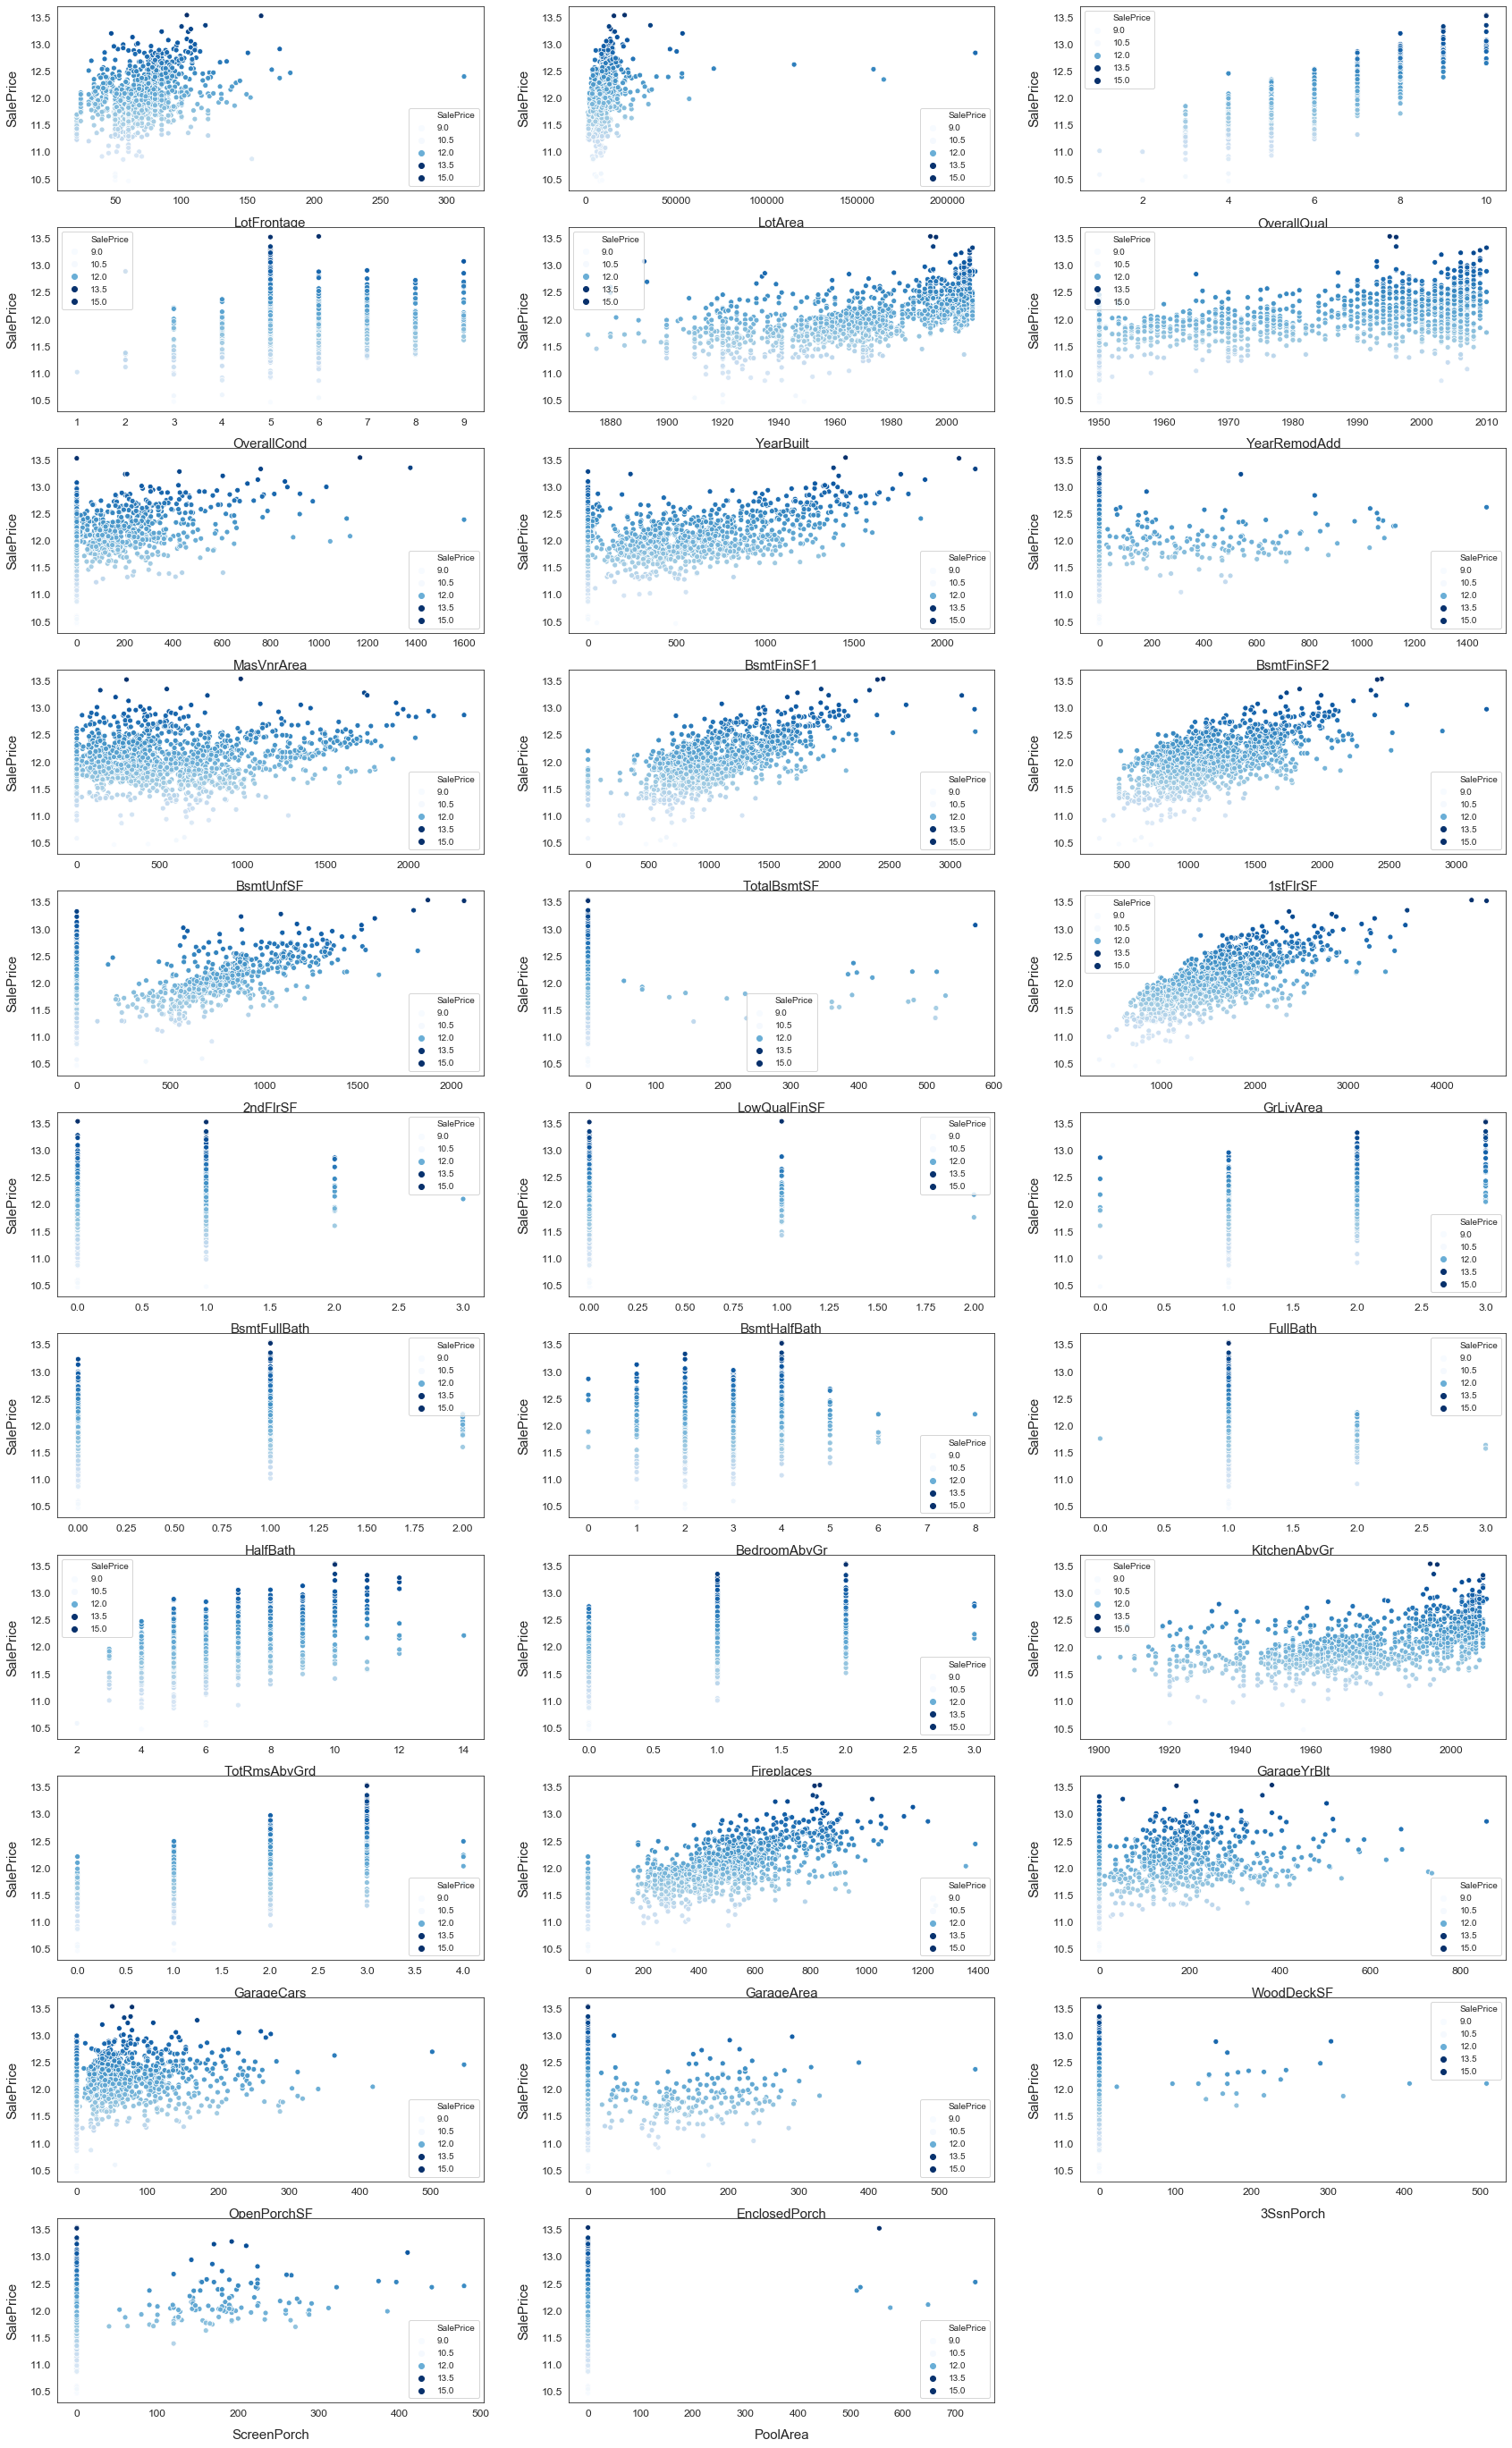

In [41]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in X.columns:
    if X[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)     
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 150))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(X[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=train)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

# Train a model

## Key features of the model training process:
- **Cross Validation:** Using 12-fold cross-validation
- **Models:** On each run of cross-validation I fit 7 models (ridge, svr, gradient boosting, random forest, xgboost, lightgbm regressors)
- **Stacking:** In addition, I trained a meta StackingCVRegressor optimized using xgboost
- **Blending:** All models trained will overfit the training data to varying degrees. Therefore, to make final predictions, I blended their predictions together to get more robust predictions.

## Setup cross validation and define error metrics

In [42]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [43]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

## Setup models

In [44]:
# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

## Train models

### Get cross validation scores for each model

In [45]:
scores = {}
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1094 (0.0200)


### Fit the models

In [46]:
print('Svr')
svr_model_full_data = svr.fit(X, train_labels)

Svr


### Generate/Dump the model

In [47]:
model_path = os.path.join(output_path,"filename.pkl")

In [48]:
joblib.dump(svr,model_path)

['E:\\Notebook\\models\\House_Pricing\\filename.pkl']

In [49]:
json_file = os.path.join(output_path,'data_file.json')
with open(json_file,'w') as file:
    json.dump(dump_file,file,indent = 4)

In [50]:
import sklearn
import shap
from sklearn.model_selection import train_test_split

# print the JS visualization code to the notebook
shap.initjs()

In [51]:
np.all(np.isfinite(X_test))

True

In [52]:
np.any(np.isnan(X_test))

False

In [53]:
print(svr.predict)
print(type(svr.predict))
wan_array = svr.predict(X)
print(wan_array[0])

<function Pipeline.predict at 0x000001FC9652D4C8>
<class 'function'>
12.240704914254614


In [54]:
def model_predict(X):
    predictions = svr.predict(X)
    return predictions

In [55]:
med = X.median().values.reshape((1,X.shape[1]))

In [56]:
explainer = shap.KernelExplainer(model_predict,med)
shap_values = explainer.shap_values(X, nsamples=100)

In [57]:
base_value = explainer.expected_value
a = np.sum(shap_values[0, :]) + base_value
print(a,type(a))

12.240704914254614 <class 'numpy.float64'>


In [58]:
all_our_features = X.columns[np.argsort(np.abs(shap_values).mean(0))]
all_out_features = X.columns
all_our_features = all_our_features[::-1]
print(len(all_our_features),type(all_our_features),all_our_features[0])
#print(all_our_features)

378 <class 'pandas.core.indexes.base.Index'> YearBuilt


In [59]:
#print(type(shap_values))
list_all = shap_values.tolist()
#print(list_all[0],len(list_all[0]),len(list_all))
list_for_all = []

for i in range(len(list_all)):
    dict_all_sample = {}
    for j in range(len(list_all[i])):
        dict_all_sample[all_out_features[j]] = list_all[i][j]
    list_for_all.append(dict_all_sample)
print(list_for_all[11])
        

{'LotFrontage': 0.0, 'LotArea': 0.0, 'OverallQual': 0.0, 'OverallCond': 0.0, 'YearBuilt': 0.024869141637237302, 'YearRemodAdd': 0.0, 'MasVnrArea': -0.013782700743017018, 'BsmtFinSF1': 0.0, 'BsmtFinSF2': 0.0, 'BsmtUnfSF': 0.0, 'TotalBsmtSF': 0.0, '1stFlrSF': 0.0, '2ndFlrSF': 0.06916347243271881, 'LowQualFinSF': 0.0, 'GrLivArea': 0.021635470161529058, 'BsmtFullBath': 0.0, 'BsmtHalfBath': 0.0, 'FullBath': 0.03045190213475968, 'HalfBath': 0.0, 'BedroomAbvGr': 0.0, 'KitchenAbvGr': 0.0, 'TotRmsAbvGrd': 0.05172027950895919, 'Fireplaces': 0.0, 'GarageYrBlt': 0.0, 'GarageCars': 0.0, 'GarageArea': 0.0, 'WoodDeckSF': 0.0, 'OpenPorchSF': 0.0, 'EnclosedPorch': 0.0, '3SsnPorch': 0.0, 'ScreenPorch': 0.0, 'PoolArea': 0.0, 'MiscVal': 0.0, 'BsmtFinType1_Unf': 0.0, 'HasWoodDeck': 0.0, 'HasOpenPorch': 0.0, 'HasEnclosedPorch': 0.0, 'Has3SsnPorch': 0.0, 'HasScreenPorch': 0.0, 'YearsSinceRemodel': 0.0, 'Total_Home_Quality': 0.04877271665867977, 'TotalSF': 0.0, 'YrBltAndRemod': 0.04946595680026583, 'Total_sqr

In [64]:
#shap.force_plot(explainer.expected_value, shap_values, X_test, link="logit")

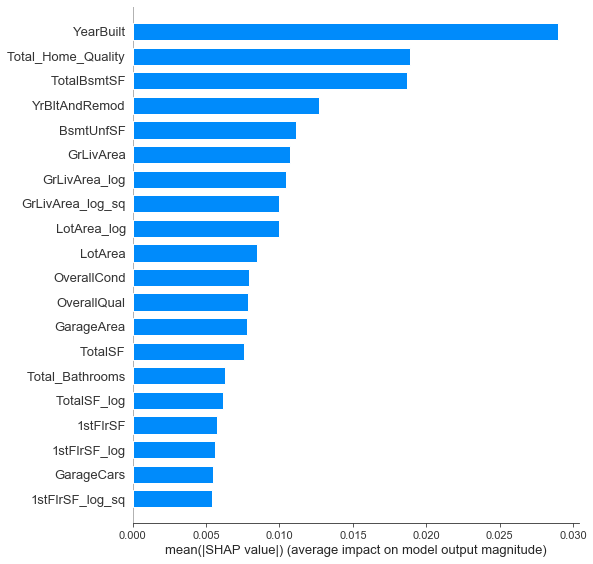

In [65]:
shap.summary_plot(shap_values, X, plot_type="bar")

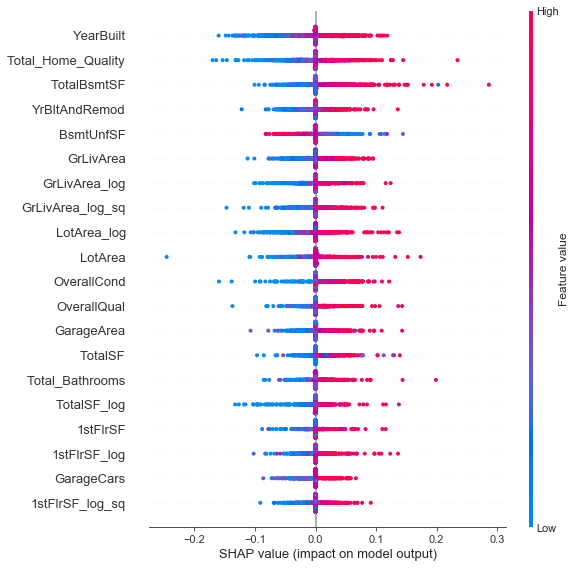

In [66]:
shap.summary_plot(shap_values, X)

In [67]:
shap_values_single = explainer.shap_values(X.iloc[11,:], nsamples=1000)
shap.force_plot(explainer.expected_value, shap_values_single, X.iloc[11,:])

In [68]:
print(np.sum(shap_values_single[0:]))
print(np.sum(shap_values[0, :]))

0.8521571193147378
0.224758822071621


In [69]:
shap_values_test = explainer.shap_values(X_test.iloc[0:100,:], nsamples=1000)


In [ ]:
#shap.force_plot(explainer.expected_value, shap_values_test, X_test.iloc[0:100,:])

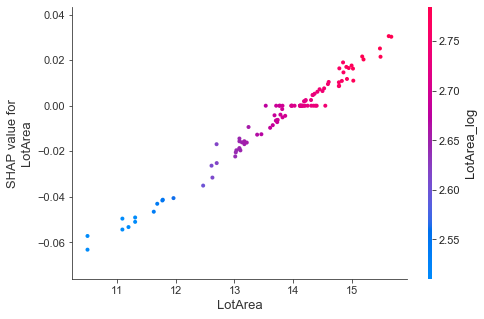

In [71]:
shap.dependence_plot("LotArea", shap_values_test, X_test.iloc[0:100,:])

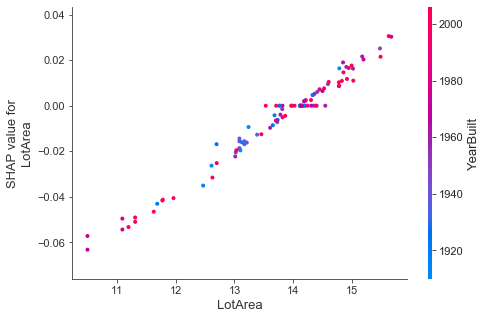

In [72]:
shap.dependence_plot('LotArea', shap_values_test, X_test.iloc[0:100,:], interaction_index="YearBuilt")

In [73]:
shap_values_norm = explainer.shap_values(X_test.iloc[0:10,:], nsamples=100)
shap.force_plot(explainer.expected_value, shap_values_norm, X_test.iloc[0:10,:])